# Backwards Optimization for Convective Mode
This notebook is created in collabartion with David Gagne, Kirsten Mayer, and Will Chapman and also some help with the following notebooks:

Lagerquist, R., and D.J. Gagne II, 2019: "Interpretation of deep learning for predicting thunderstorm rotation: Python tutorial". https://github.com/djgagne/ams-ml-python-course/blob/master/module_4/ML_Short_Course_Module_4_Interpretation.ipynb.

https://github.com/Unidata/users-workshop-2023/blob/main/3_wednesday/breakout_sessions/XAI/PredictENSO_BO.ipynb



In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import copy
import scipy

import pickle


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.compat.v1.disable_eager_execution()
from keras import backend as K
import sys
sys.setrecursionlimit(1500)

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12


from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential


#plotting with Cartopy. 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib import rc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker

import scipy as sp
import scipy.ndimage

2024-06-04 16:41:09.789635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def smooth_it(Patty):
    sigma_y = 1.5
    sigma_x = 1.5
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.gaussian_filter(Patty, sigma, mode='constant')
    return y

## Defintions for Backward Optimization

In [3]:
def _gradient_descent_for_bwo(
        cnn_model_object, loss_tensor, init_function_or_matrices,
        num_iterations, learning_rate):
    """Does gradient descent (the nitty-gritty part) for backwards optimization.

    :param cnn_model_object: Trained instance of `keras.models.Model`.
    :param loss_tensor: Keras tensor, defining the loss function to be
        minimized.
    :param init_function_or_matrices: Either a function or list of numpy arrays.

    If function, will be used to initialize input matrices.  See
    `create_gaussian_initializer` for an example.

    If list of numpy arrays, these are the input matrices themselves.  Matrices
    should be processed in the exact same way that training data were processed
    (e.g., normalization method).  Matrices must also be in the same order as
    training matrices, and the [q]th matrix in this list must have the same
    shape as the [q]th training matrix.

    :param num_iterations: Number of gradient-descent iterations (number of
        times that the input matrices are adjusted).
    :param learning_rate: Learning rate.  At each iteration, each input value x
        will be decremented by `learning_rate * gradient`, where `gradient` is
        the gradient of the loss function with respect to x.
    :return: list_of_optimized_input_matrices: length-T list of optimized input
        matrices (numpy arrays), where T = number of input tensors to the model.
        If the input arg `init_function_or_matrices` is a list of numpy arrays
        (rather than a function), `list_of_optimized_input_matrices` will have
        the exact same shape, just with different values.
    """

    if isinstance(cnn_model_object.input, list):
        list_of_input_tensors = cnn_model_object.input
    else:
        list_of_input_tensors = [cnn_model_object.input]

    num_input_tensors = len(list_of_input_tensors)
    
    print(loss_tensor)
    print(list_of_input_tensors)
        
    list_of_gradient_tensors = tf.compat.v1.keras.backend.gradients(loss_tensor, list_of_input_tensors)     
    
    for i in range(num_input_tensors):
        list_of_gradient_tensors[i] /= K.maximum(
            K.sqrt(K.mean(list_of_gradient_tensors[i] ** 2)),
            K.epsilon()
        )

    inputs_to_loss_and_gradients = K.function(
        list_of_input_tensors + [K.learning_phase()],
        ([loss_tensor] + list_of_gradient_tensors)
    )

    if isinstance(init_function_or_matrices, list):
        list_of_optimized_input_matrices = copy.deepcopy(
            init_function_or_matrices)
    else:
        list_of_optimized_input_matrices = [None] * num_input_tensors

        for i in range(num_input_tensors):
            these_dimensions = np.array(
                [1] + list_of_input_tensors[i].get_shape().as_list()[1:],
                dtype=int)

            list_of_optimized_input_matrices[i] = init_function_or_matrices(
                these_dimensions)

    for j in range(num_iterations):
        these_outputs = inputs_to_loss_and_gradients(
            list_of_optimized_input_matrices + [0])

        if np.mod(j, 1000) == 0:
            print('Loss after {0:d} of {1:d} iterations: {2:.2e}'.format(
                j, num_iterations, these_outputs[0]))

        for i in range(num_input_tensors):
            list_of_optimized_input_matrices[i] -= (
                these_outputs[i + 1] * learning_rate)

    print('Loss after {0:d} iterations: {1:.2e}'.format(
        num_iterations, these_outputs[0]))
    return list_of_optimized_input_matrices


def bwo_for_class(
        cnn_model_object, target_class, init_function_or_matrices,
        num_iterations=4000,
        learning_rate=0.00000001):
    """Does backwards optimization to maximize probability of target class.

    :param cnn_model_object: Trained instance of `keras.models.Model`.
    :param target_class: Synthetic input data will be created to maximize
        probability of this class.
    :param init_function_or_matrices: See doc for `_gradient_descent_for_bwo`.
    :param num_iterations: Same.
    :param learning_rate: Same.
    :return: list_of_optimized_input_matrices: Same.
    """

    target_class = int(np.round(target_class))
    num_iterations = int(np.round(num_iterations))

    assert target_class >= 0
    assert num_iterations > 0
    assert learning_rate > 0.
    assert  learning_rate < 1.

    num_output_neurons = (
        cnn_model_object.layers[-1].output.get_shape().as_list()[-1]
    )

    if num_output_neurons == 1:
        assert target_class <= 1

        if target_class == 1:
            loss_tensor = K.mean(
                (cnn_model_object.layers[-1].output[..., 0] - 1) ** 2
            )
        else:
            loss_tensor = K.mean(
                cnn_model_object.layers[-1].output[..., 0] ** 2
            )
    else:
        assert target_class < num_output_neurons

        loss_tensor = K.mean(
            (cnn_model_object.layers[-1].output[..., target_class] - 1) ** 2
        )

    return _gradient_descent_for_bwo(
        cnn_model_object=cnn_model_object, loss_tensor=loss_tensor,
        init_function_or_matrices=init_function_or_matrices,
        num_iterations=num_iterations, learning_rate=learning_rate)

## Defintions for Radar Image

In [4]:
def radar_colormap():
    r"""Returns an NWS colormap.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    """ 
 
    nws_reflectivity_colors = ["#ffffff",  # 0
                               "#04e9e7",  # 5
                               "#019ff4",  # 10
                               "#0300f4",  # 15
                               "#02fd02",  # 20
                               "#01c501",  # 25
                               "#008e00",  # 30
                               "#fdf802",  # 35
                               "#e5bc00",  # 40
                               "#fd9500",  # 45
                               "#fd0000",  # 50
                               "#d40000",  # 55
                               "#bc0000",  # 60
                               "#f800fd",  # 65
                               "#9854c6",  # 70
                               "#4B0082",  # 75
                               "#000000"]
                                
    cmap = ListedColormap(nws_reflectivity_colors)
    
    return cmap


def draw_box_plot(ax, img, cbar_shrink=0.35):
    r"""Creates a pre-packaged display for indidivual or summary
    svrimg images.  Modifies an input axis.
    
    Parameters
    ----------
    ax: matplotlib.pyplot.axes.Axes
        Modifiable matplotlib.pyplot axis.
    img: (M, N) ndarray
        SVRIMG radar image
    cbar_shrink: numeric
        Value between 0 - 1.  This will be replacedwith kwargs in 
        future for more customization. Default is 0.35.
    Returns
    -------
    ax: matplotlib.pyplot.axes.Axes
        Modified matplotlib.pyplot axis.
    """ 

    cmap, norm = radar_norm()
    mmp = ax.imshow(np.flipud(img), cmap=cmap, norm=norm)
    #ax.arrow(125.5, 119, 0, -0.0001, head_width=10, head_length=15, fc='k', ec='k', zorder=10)
    #ax.text(121, 130, "N", fontsize=35, zorder=10)
    
    #plt.colorbar(mmp, ax=ax, shrink=cbar_shrink, pad=0.01)
    
    return ax

def radar_norm():
    r"""Return a colormap and normalization that allow you to represent
    radar data with colors every 5 dBZ that mimics the official NWS
    radar images.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    norm: BoundaryNorm
        Normalization for 5 dBZ levels (0-80).
    """ 

    cmap = radar_colormap()
    classes = np.array(list(range(0, 85, 5)))
    norm = BoundaryNorm(classes, ncolors=cmap.N)    
    
    return cmap, norm

## Load the Data

In [5]:
#load the training/testing/validation datasets
with open("/share/jcorner_data/pkls/1996_2011_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/pkls/2012_2013_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/pkls/2014_2017_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

x_train shape: (4560, 136, 136, 1)
4560 train samples
309 validate samples
920 test samples


# Load the Model

In [6]:
model = tf.keras.models.load_model('/share/jcorner_data/models/future_modes_v2.h5')

2024-06-04 16:41:12.124565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-06-04 16:41:12.138166: W tensorflow/c/c_api.cc:305] Operation '{name:'dense/bias/Assign' id:96 op device:{requested: '', assigned: ''} def:{{{node dense/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense/bias, dense/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Calculate Backward Optimization

In [7]:
#create random init state data similar to input data 
init_state = np.random.random(size=x_train[0,:,:,:].shape)
init_state = init_state/np.max(init_state)

In [8]:
#call the backwards optimization defintion
class_optimized_predictor_matrix_norm0 = bwo_for_class(
    cnn_model_object=model, target_class=0,
    init_function_or_matrices=[0*np.expand_dims(init_state, axis=0)],
    num_iterations= 1,
    learning_rate=0.1)

Tensor("Mean:0", shape=(), dtype=float32)
[<tf.Tensor 'input_1:0' shape=(None, 136, 136, 1) dtype=float32>]
Loss after 0 of 1 iterations: 7.81e-03
Loss after 1 iterations: 7.81e-03


2024-06-04 16:41:12.346754: W tensorflow/c/c_api.cc:305] Operation '{name:'count/Assign' id:154 op device:{requested: '', assigned: ''} def:{{{node count/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count, count/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [9]:
#call the backwards optimization defintion
class_optimized_predictor_matrix_norm1 = bwo_for_class(
    cnn_model_object=model, target_class=1,
    init_function_or_matrices=[0*np.expand_dims(init_state, axis=0)],
    num_iterations= 1,
    learning_rate=0.1)

Tensor("Mean_2:0", shape=(), dtype=float32)
[<tf.Tensor 'input_1:0' shape=(None, 136, 136, 1) dtype=float32>]
Loss after 0 of 1 iterations: 9.84e-01
Loss after 1 iterations: 9.84e-01


In [10]:
#call the backwards optimization defintion
class_optimized_predictor_matrix_norm2 = bwo_for_class(
    cnn_model_object=model, target_class=2,
    init_function_or_matrices=[0*np.expand_dims(init_state, axis=0)],
    num_iterations= 1,
    learning_rate=0.1)

Tensor("Mean_4:0", shape=(), dtype=float32)
[<tf.Tensor 'input_1:0' shape=(None, 136, 136, 1) dtype=float32>]
Loss after 0 of 1 iterations: 9.99e-01
Loss after 1 iterations: 9.99e-01


In [11]:
#call the backwards optimization defintion
class_optimized_predictor_matrix_norm3 = bwo_for_class(
    cnn_model_object=model, target_class=3,
    init_function_or_matrices=[0*np.expand_dims(init_state, axis=0)],
    num_iterations= 1,
    learning_rate=0.1)

Tensor("Mean_6:0", shape=(), dtype=float32)
[<tf.Tensor 'input_1:0' shape=(None, 136, 136, 1) dtype=float32>]
Loss after 0 of 1 iterations: 8.46e-01
Loss after 1 iterations: 8.46e-01


## Plot the Results

In [12]:
# Plot
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
%matplotlib inline

#load a radarcolormap
cmap = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap.N)

lookup = ['Cellular','Multicell', 'Linear', 'Other']

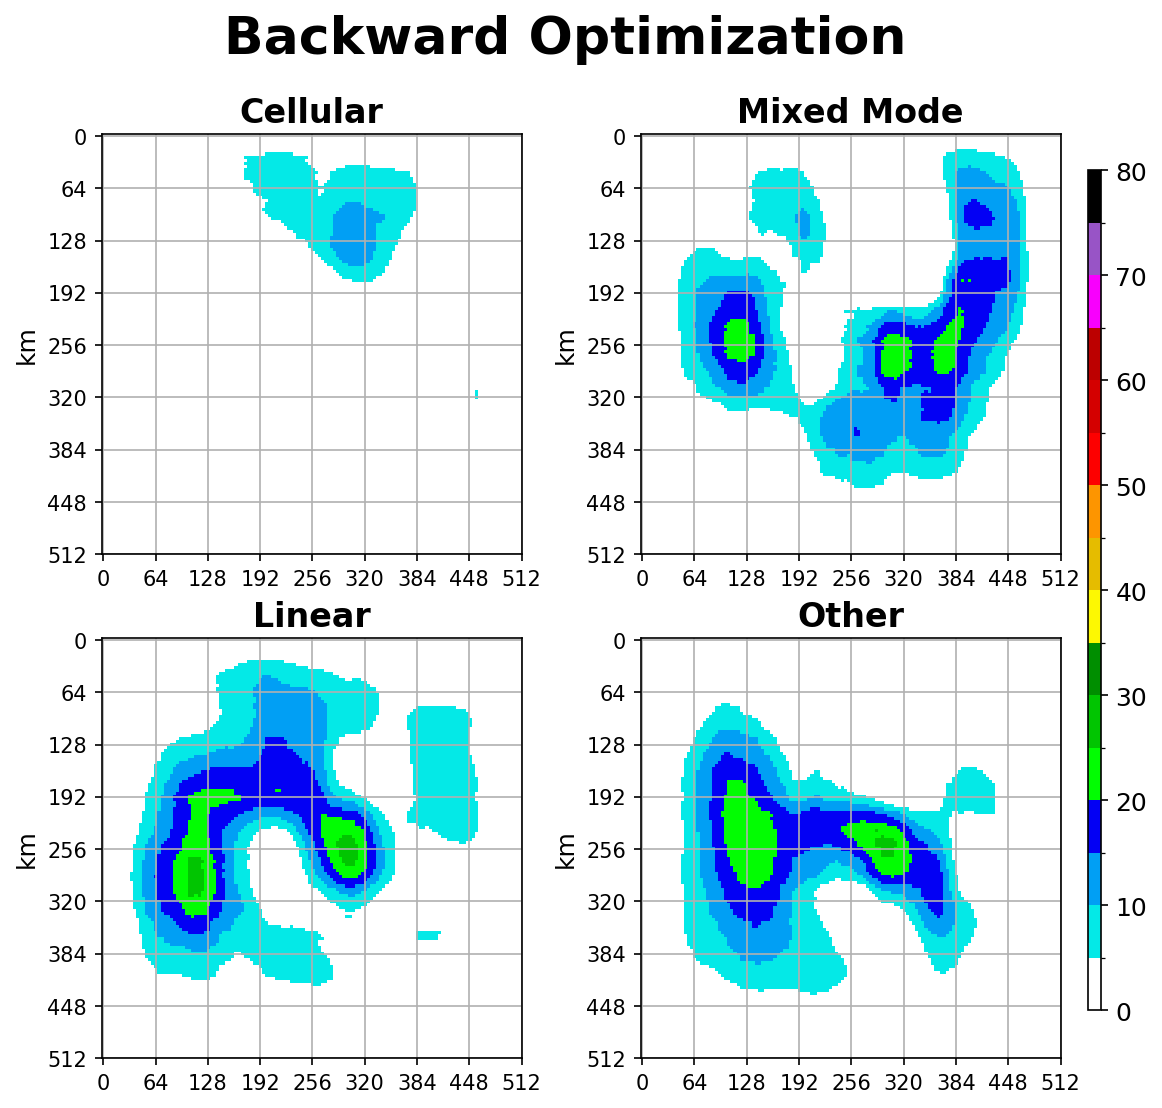

In [14]:
mode_labels = ['Cellular','Mixed Mode', 'Linear', 'Other']

fig = plt.figure(figsize=(8.5,8))

#iterate through each class
for i in range(4):
    ax = plt.subplot(2,2,i+1)

    #reshape and smooth the current class of bwo data
    bwo_map = locals()[f'class_optimized_predictor_matrix_norm{i}'][0].reshape(136,136)
    
    #plot the data
    mmp = ax.imshow(bwo_map * 80, cmap=cmap, norm=norm)

    ax.set_title(mode_labels[i], fontsize=16).set_weight('bold')
    ax.set_yticks(list(range(0, 153, 17)))
    ax.set_yticklabels(np.arange(0,523,64), fontsize=10)
    ax.set_xticks(list(range(0, 153, 17)))
    ax.set_xticklabels(np.arange(0,523,64), fontsize=10)
    #ax.set_xlabel("km")
    ax.set_ylabel("km")
    ax.grid()

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
plt.colorbar(mmp, ax=ax, pad=0.01, cax=cbar_ax)

plt.suptitle('Backward Optimization', size=25).set_weight('bold')
plt.savefig('/home/jovyan/Future_Modes/Plots/bwo_plots.png', format='png', dpi=500, bbox_inches='tight')